In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from proj1_helpers import *
from implementations import *
#from validation_utils import *
%load_ext autoreload
%autoreload 2

from utils import *

## Load the training data into feature matrix, class labels, and event ids:

In [7]:
import datetime
DATA_TRAIN_PATH = '../data/train.csv' 
labels, input_data, ids = load_csv_data(DATA_TRAIN_PATH)

In [8]:
# standardize the data : 
x, mean_x, std_x = standardize(input_data)
y, tx = build_model_data(x, labels)

In [9]:
print(f'shape y : {y.shape}, shape x : {tx.shape}')

shape y : (250000,), shape x : (250000, 31)


## Do your thing crazy machine learning thing here :) ...

## Least Squares GD

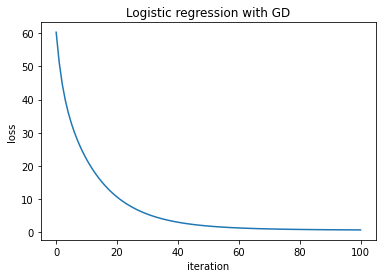

Final loss is 0.71


In [11]:
max_iters = 100
gamma = 0.01
initial_w = np.ones((tx.shape[1]))

plt.title('Logistic regression with GD')
w, loss = least_squares_GD(y, tx, initial_w, max_iters, gamma, plot_loss = True)
print("Final loss is {:.2f}".format(loss))

# Ridge regression

In [68]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-7, -2, 15)

    # split the data, and return train and test data
    x_train, y_train, x_test, y_test = split_data(x, y, ratio, seed)

    # form train and test data with polynomial basis function
    x_train_poly = build_poly(x_train, degree)
    x_test_poly = build_poly(x_test, degree)

    mse_tr = []
    mse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ridge regression with a given lambda
        w, mse_tr_ = ridge_regression(y_train, x_train_poly, lambda_)
        mse_te_ = compute_mse(y_test, x_test_poly, w)
        mse_tr.append(mse_tr_)
        mse_te.append(mse_te_)
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training MSE={tr:.3f}, Testing MSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=mse_tr[ind], te=mse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(mse_tr, mse_te, lambdas, degree)

proportion=0.7, degree=1, lambda=0.000, Training MSE=0.339, Testing MSE=0.342
proportion=0.7, degree=1, lambda=0.000, Training MSE=0.339, Testing MSE=0.342
proportion=0.7, degree=1, lambda=0.000, Training MSE=0.339, Testing MSE=0.342
proportion=0.7, degree=1, lambda=0.000, Training MSE=0.339, Testing MSE=0.342
proportion=0.7, degree=1, lambda=0.000, Training MSE=0.339, Testing MSE=0.342
proportion=0.7, degree=1, lambda=0.000, Training MSE=0.339, Testing MSE=0.342
proportion=0.7, degree=1, lambda=0.000, Training MSE=0.339, Testing MSE=0.342
proportion=0.7, degree=1, lambda=0.000, Training MSE=0.339, Testing MSE=0.342
proportion=0.7, degree=1, lambda=0.000, Training MSE=0.339, Testing MSE=0.342
proportion=0.7, degree=1, lambda=0.000, Training MSE=0.339, Testing MSE=0.342
proportion=0.7, degree=1, lambda=0.000, Training MSE=0.340, Testing MSE=0.342
proportion=0.7, degree=1, lambda=0.001, Training MSE=0.341, Testing MSE=0.344
proportion=0.7, degree=1, lambda=0.002, Training MSE=0.344, Test

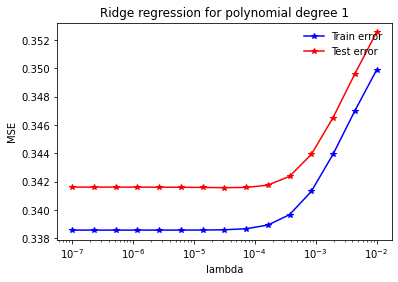

In [69]:
seed = 6
degree = 1
split_ratio = 0.7
ridge_regression_demo(x, y, degree, split_ratio, seed)

## Cross validation on ridge regression

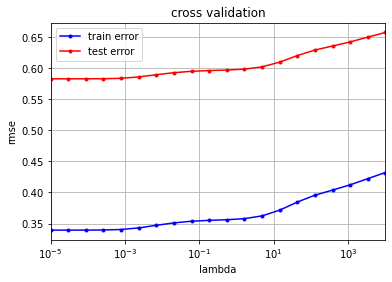

In [73]:
def cross_validation_demo():
    seed = 1
    degree = 0
    k_fold = 4
    bd_left = -5
    bd_right = 4
    lambdas = np.logspace(bd_left, bd_right, 20)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []

    # cross validation
    for lambda_ in lambdas:
        loss_train = []
        loss_test = []
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            loss_train.append(loss_tr)
            loss_test.append(loss_te)
        rmse_tr.append(np.mean(loss_train))
        rmse_te.append(np.mean(loss_test))

    cross_validation_visualization(lambdas, rmse_tr, rmse_te, bd_left, bd_right)

cross_validation_demo()

# Logistic Regression with GD:

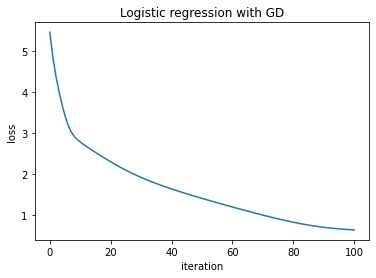

Final loss is 0.63


In [4]:
max_iters = 100
gamma = 0.1
initial_w = np.ones((tx.shape[1]))

plt.title('Logistic regression with GD')
w, loss = logistic_regression(y, tx, initial_w, max_iters, gamma, plot_loss = True)
print("Final loss is {:.2f}".format(loss))

## Logistic Regression + regularisation with GD: : 

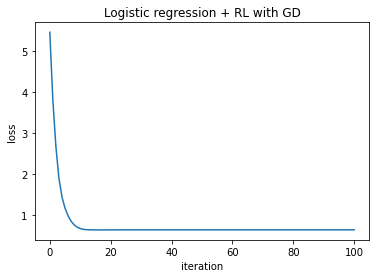

Final loss is 0.63


In [5]:
max_iters = 100
gamma = 0.1
lambda_ = 1
initial_w = np.ones((tx.shape[1]))

plt.title('Logistic regression + RL with GD')
w, loss = reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma, plot_loss = True)
print("Final loss is {:.2f}".format(loss))

# Look at the results : 


# 1. Split the data

In [6]:
ratio = 0.7
tx_tr, tx_te, y_tr, y_te = split_data(tx, y, ratio)

# 2. Handle outliers 

# 3 Accuracy of the models

In [ ]:
#weights, loss = least_squares(y_tr, tx_tr)
y_pred = predict_labels(w, tx_te)
accu  = accuracy(y_pred,y_te)
print("accuracy:",accu)

# 4. Confusion matrix 

Text(33.0, 0.5, 'expected')

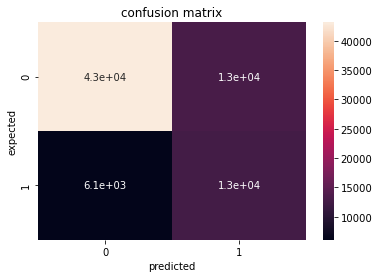

In [12]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
#confusion matrix
plt.figure(1)
cm=confusion_matrix(y_pred,y_te)
sn.heatmap(cm,annot=True)
plt.title("confusion matrix")
plt.xlabel("predicted")
plt.ylabel("expected")


## Generate predictions and save ouput in csv format for submission:

In [13]:
DATA_TEST_PATH = '../data/test.csv'  # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [14]:
weights = weights[1:31]
y_prediction = predict_labels(weights, tX_test)
y_prediction.shape

(568238, 1)

In [15]:
OUTPUT_PATH = '../data/pred.csv' # TODO: fill in desired name of output file for submission
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)